In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [2]:
# Import csv file and read it into a dataframe
csv_file_path = 'datasets/ev_data.csv'
df =pd.read_csv(csv_file_path)

# Inspect the first or last few rows of the dataset to see that the data loaded properly and what you're working with
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
1,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
2,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


In [3]:
# get a better idea of the dataset
df.describe()


,year,value
count,12654.000000,1.265400e+04
mean,2019.822112,4.273742e+05
std,5.476494,6.860498e+06
min,2010.000000,1.200000e-06
25%,2016.000000,2.000000e+00
50%,2020.000000,1.300000e+02
75%,2022.000000,5.500000e+03
max,2035.000000,4.400000e+08


In [4]:
# Check how many non null values each column has
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      12654 non-null  object 
 1   category    12654 non-null  object 
 2   parameter   12654 non-null  object 
 3   mode        12654 non-null  object 
 4   powertrain  12654 non-null  object 
 5   year        12654 non-null  int64  
 6   unit        12654 non-null  object 
 7   value       12654 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 791.0+ KB


In [5]:
# how many rows have data
df.count()

region        12654
category      12654
parameter     12654
mode          12654
powertrain    12654
year          12654
unit          12654
value         12654
dtype: int64

In [6]:
# find the datatypes
df.dtypes

region         object
category       object
parameter      object
mode           object
powertrain     object
year            int64
unit           object
value         float64
dtype: object

In [7]:
# Check for missing values in the dataset
print(df.isnull().sum())

region        0
category      0
parameter     0
mode          0
powertrain    0
year          0
unit          0
value         0
dtype: int64


In [8]:
# Remove duplicate rows
df = df.drop_duplicates()

In [9]:
#Check dataset to see if any duplicates were dropped
df.describe()

,year,value
count,12654.000000,1.265400e+04
mean,2019.822112,4.273742e+05
std,5.476494,6.860498e+06
min,2010.000000,1.200000e-06
25%,2016.000000,2.000000e+00
50%,2020.000000,1.300000e+02
75%,2022.000000,5.500000e+03
max,2035.000000,4.400000e+08


In [10]:
# list the  countries/regions where we have data
df['region'].unique()

array(['Australia', 'Austria', 'Belgium', 'Brazil', 'Bulgaria', 'Canada',
       'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'EU27', 'Europe',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico',
       'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
       'Rest of the world', 'Romania', 'Seychelles', 'Slovakia',
       'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
       'Thailand', 'Turkiye', 'United Arab Emirates', 'United Kingdom',
       'USA', 'World'], dtype=object)

In [11]:
# list the unique values in the parameter column
df['parameter'].unique()

array(['EV stock share', 'EV sales share', 'EV sales', 'EV stock',
       'EV charging points', 'Electricity demand', 'Oil displacement Mbd',
       'Oil displacement, million lge'], dtype=object)

In [12]:
# list the unique values in the category column
df['category'].unique()

array(['Historical', 'Projection-STEPS', 'Projection-APS'], dtype=object)

In [13]:
# list the unique values in the mode column
df['mode'].unique()

array(['Cars', 'EV', 'Buses', 'Vans', 'Trucks'], dtype=object)

In [14]:
# list the unique values in the powertrain column
df['powertrain'].unique()

array(['EV', 'BEV', 'PHEV', 'Publicly available fast',
       'Publicly available slow', 'FCEV'], dtype=object)

In [15]:
# list the unique values in the unit column
df['unit'].unique()

array(['percent', 'Vehicles', 'charging points', 'GWh',
       'Milion barrels per day', 'Oil displacement, million lge'],
      dtype=object)

In [16]:
# Filter data for fast and slow charging points (excluding other powertrains)
df_charging = df.loc[
    (df['powertrain'].isin(['Publicly available fast', 'Publicly available slow'])) &
    (df['parameter'] == 'EV charging points') &
    (df['category'] == 'Historical') &
    (df['unit'] == 'charging points') &
    (df['year'] >= 2011) & (df['year'] <= 2023)
]

# Group by region, year, and powertrain (fast vs. slow) and sum the values
df_combined_charging = df_charging.groupby(['region', 'year', 'powertrain'], as_index=False)['value'].sum()

# Pivot the data to create separate columns for fast and slow charging points
df_pivot_charging = df_combined_charging.pivot_table(
    index=['region', 'year'],
    columns='powertrain',
    values='value',
    aggfunc='sum'
).reset_index()

# Fill any missing values (if there are any regions with no data for a specific powertrain)
df_pivot_charging = df_pivot_charging.fillna(0)

# Create the Total column by summing the fast and slow charging points
df_pivot_charging['total_charging_points'] = df_pivot_charging['Publicly available fast'] + df_pivot_charging['Publicly available slow']

# Remove the multi-level column index (caused by the pivot)
df_pivot_charging.columns.name = None  # This removes the "powertrain" label

# Reset the index to make it a clean dataframe without the index column
df_pivot_charging = df_pivot_charging.reset_index(drop=True)

# Sort the data by region and year
df_pivot_charging = df_pivot_charging.sort_values(by=['region', 'year'])

# Display the final dataframe without an index
print(df_pivot_charging.to_string(index=False))


        region  year  Publicly available fast  Publicly available slow  total_charging_points
     Australia  2017                     40.0                    440.0                  480.0
     Australia  2018                     61.0                    670.0                  731.0
     Australia  2019                      0.0                   1700.0                 1700.0
     Australia  2020                      0.0                   2300.0                 2300.0
     Australia  2021                    320.0                   2000.0                 2320.0
     Australia  2022                    470.0                   2100.0                 2570.0
     Australia  2023                    660.0                   2100.0                 2760.0
       Austria  2011                      0.1                      0.1                    0.2
       Austria  2012                      0.1                      0.1                    0.2
       Austria  2013                      0.1               

In [17]:
# Combine data for all vehicles (cars, trucks, vans, buses)
df_evsales = df.loc[
    (df['year'] >= 2011) &
    (df['year'] <= 2023) &
    (df['category']== 'Historical') &
    (df['parameter']== 'EV sales') 
]
# Group by region, year, and parameter, summing the values for each mode (cars, trucks, vans, buses)
ev_sales_all = df_evsales.groupby(
    ['region', 'year', 'parameter'], as_index=False)['value'].sum()

# Display the result
ev_sales_all.head()



,region,year,parameter,value
0,Australia,2011,EV sales,49.0
1,Australia,2012,EV sales,250.0
2,Australia,2013,EV sales,290.0
3,Australia,2014,EV sales,1320.0
4,Australia,2015,EV sales,1760.0


In [18]:
# Merge the charging data with the EV sales share data on region and year 
merged_data_value = pd.merge(ev_sales_all, df_pivot_charging, 
                       on= ['region','year'], how='inner')

# Perform a regression analysis, e.g., using statsmodels or scikit-learn
import statsmodels.api as sm

# Set x and y axis data
X = merged_data_value['total_charging_points']
y = merged_data_value['value']

# Add a constant for the intercept in the regression
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.113e+04
Date:                Thu, 30 Jan 2025   Prob (F-statistic):          1.04e-277
Time:                        14:21:41   Log-Likelihood:                -5082.9
No. Observations:                 371   AIC:                         1.017e+04
Df Residuals:                     369   BIC:                         1.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.199e+

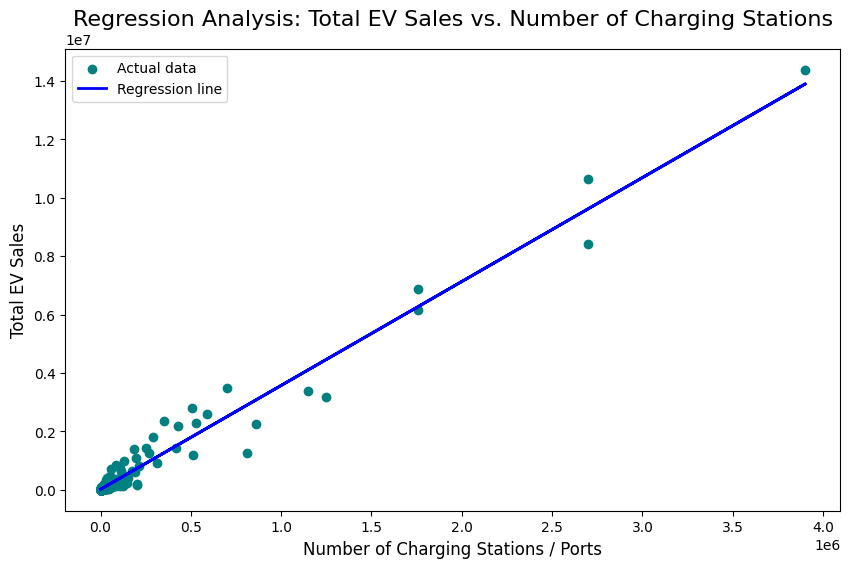

R-squared: 0.97
Mean Squared Error: 46525962233.86


In [19]:

# Prepare data for regression analysis
# X = number of charging ports (independent variable)
# Y = total EV sales (dependent variable)
X = merged_data_value[['total_charging_points']]  
Y = merged_data_value[['value']]

# Perform Linear Regression
regressor = LinearRegression()
regressor.fit(X, Y)

# Predict the results
Y_pred = regressor.predict(X)

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot of actual data
plt.scatter(X, Y, color='teal', label='Actual data')

# Plot the regression line
plt.plot(X, Y_pred, color='blue', linewidth=2, label='Regression line')

# Add titles and labels
plt.title('Regression Analysis: Total EV Sales vs. Number of Charging Stations', fontsize=16)
plt.xlabel('Number of Charging Stations / Ports', fontsize=12)
plt.ylabel('Total EV Sales', fontsize=12)
plt.legend()

# Show the plot
plt.show()

# Step 4: Calculate R-squared and Mean Squared Error (MSE) for model evaluation
r_squared = regressor.score(X, Y)
mse = mean_squared_error(Y, Y_pred)

# Print out the results
print(f'R-squared: {r_squared:.2f}')
print(f'Mean Squared Error: {mse:.2f}')

# plt.savefig()


In [20]:
# Filter for relevant 'parameter' values (EV stock share or EV sales share)
# Filter by 'EV stock share' or 'EV sales share'
ev_adoption_data = df[df['parameter'].isin(['EV stock share'])]

# Filter for the units we're interested in
ev_adoption_data = ev_adoption_data[ev_adoption_data['unit'].isin(['percent'])]


# Only keep relevant columns: region (country), year, and the value (EV adoption percentage or vehicles)
ev_adoption_data = ev_adoption_data[['region', 'year', 'parameter', 'value']]

# Check how many rows are left after filtering
print(ev_adoption_data.shape)
print(ev_adoption_data.head())

# Check if there are still duplicates when considering region, year, and parameter
duplicates = ev_adoption_data[ev_adoption_data.duplicated(subset=['region', 'year', 'parameter'], keep=False)]
print("Duplicates found:")
print(duplicates)



(1529, 4)
       region  year       parameter    value
0   Australia  2011  EV stock share  0.00039
7   Australia  2012  EV stock share  0.00240
12  Australia  2013  EV stock share  0.00460
19  Australia  2014  EV stock share  0.01400
24  Australia  2015  EV stock share  0.02700
Duplicates found:
        region  year       parameter    value
220    Belgium  2010  EV stock share   0.0190
222    Belgium  2010  EV stock share   0.0110
223    Belgium  2010  EV stock share   0.0013
224    Belgium  2010  EV stock share   0.0013
225    Belgium  2011  EV stock share   0.0040
...        ...   ...             ...      ...
12643    World  2035  EV stock share  11.0000
12646    World  2035  EV stock share  20.0000
12648    World  2035  EV stock share  18.0000
12650    World  2035  EV stock share  31.0000
12653    World  2035  EV stock share   9.0000

[1390 rows x 4 columns]


In [21]:
# Filter data for the years 2011 to 2023
ev_adoption_data = ev_adoption_data[(ev_adoption_data['year'] >= 2011) & (ev_adoption_data['year'] <= 2023)]

# Aggregate duplicates by taking the mean of the 'value' for each combination of region, year, and parameter
ev_adoption_data = ev_adoption_data.groupby(['region', 'year', 'parameter'], as_index=False)['value'].mean()

# Verify the shape after aggregation
print("Data after aggregation:", ev_adoption_data.shape)

ev_adoption_data.dtypes

Data after aggregation: (442, 4)


region        object
year           int64
parameter     object
value        float64
dtype: object

year           2011     2012     2013     2014     2015      2016      2017  \
region                                                                        
Australia  0.000390  0.00240  0.00460  0.01400  0.02700  0.037000  0.052000   
Austria    0.022000  0.03300  0.05300  0.08900  0.14000  0.240000  0.380000   
Belgium    0.010625  0.02470  0.03095  0.09840  0.18835  0.284025  0.389925   
Brazil          NaN      NaN      NaN  0.00016  0.00059  0.000810  0.001500   
Canada     0.001555  0.00674  0.01410  0.02730  0.02877  0.044067  0.070697   

year           2018      2019      2020      2021      2022     2023  
region                                                                
Australia  0.077000  0.140000  0.180000  0.320000  0.590000  1.20000  
Austria    0.530000  0.750000  1.200000  2.100000  3.000000  4.40000  
Belgium    0.495500  0.645500  0.958250  1.329000  1.834500  3.81500  
Brazil     0.002369  0.006820  0.008270  0.032225  0.081000  0.13025  
Canada     0.102870 

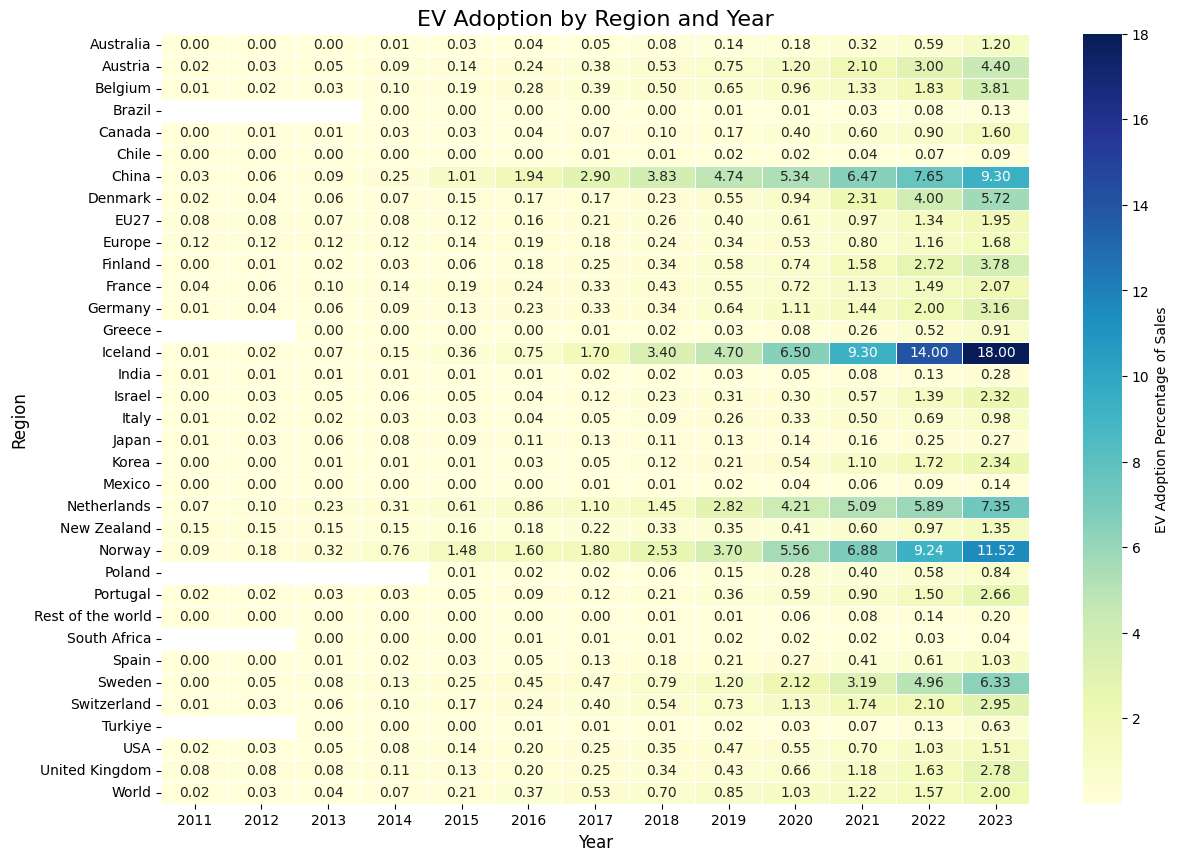

In [22]:
# Pivot the data: rows = region, columns = year, values = EV adoption percentage (or vehicles)
pivot_data = ev_adoption_data.pivot(index='region', columns='year', values='value')

# Verify the pivoted data
print(pivot_data.head())

# Create the heatmap
plt.figure(figsize=(14, 10))  # Adjust figure size as necessary
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'EV Adoption Percentage of Sales'}, linewidths=0.5)

# Add titles and labels
plt.title('EV Adoption by Region and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Region', fontsize=12)

# Show the plot
plt.show()



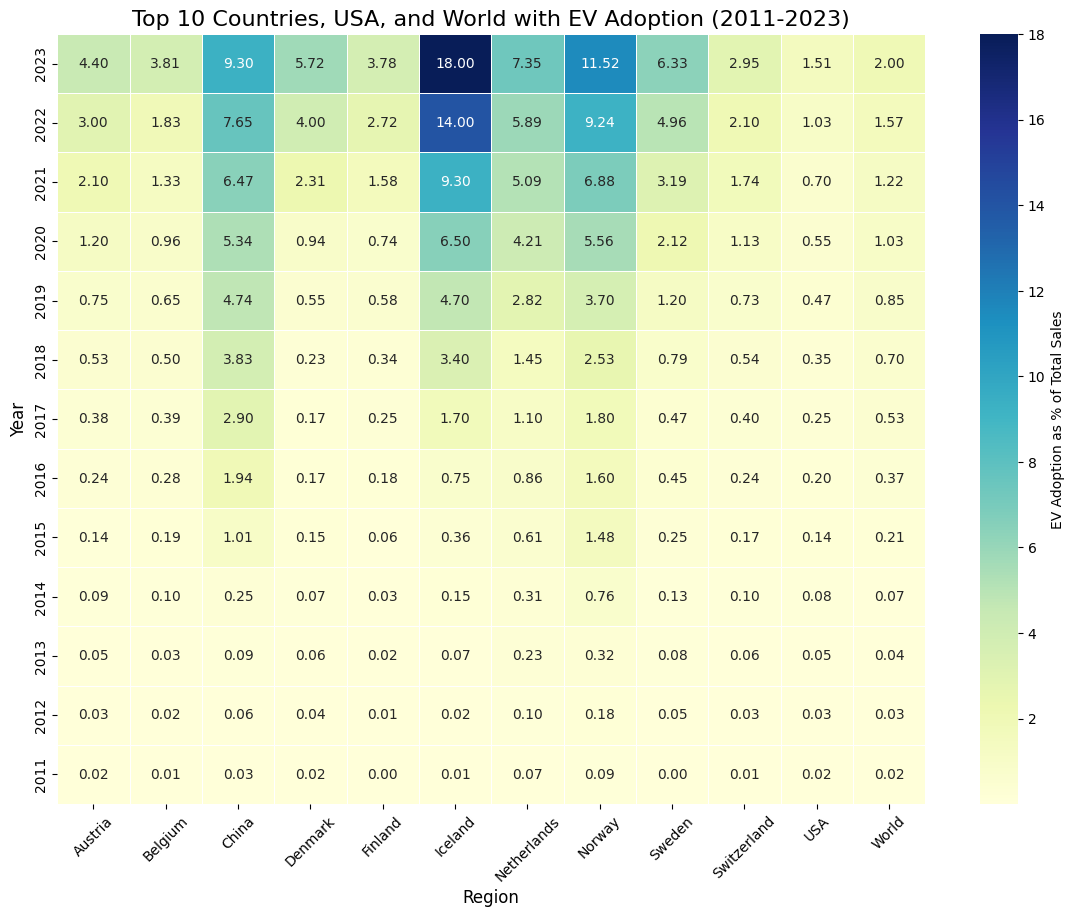

In [23]:
# Sum EV adoption by country (region) across all years
total_ev_adoption_by_country = ev_adoption_data.groupby('region')['value'].sum().reset_index()

# Sort by total EV adoption value and pick the top 10 countries
top_10_countries = total_ev_adoption_by_country.sort_values(by='value', ascending=False).head(10)

# Add 'US' and 'World' to the list of top countries
countries_of_interest = top_10_countries['region'].tolist()
countries_of_interest.extend(['USA', 'World'])  # Add 'USA' and 'World' to the list

# Filter the data for the countries of interest (top 10 + USA + World)
ev_adoption_data_filtered = ev_adoption_data[ev_adoption_data['region'].isin(countries_of_interest)]

# Pivot the data to get years as rows and countries as columns
pivot_data = ev_adoption_data_filtered.pivot(index='year', columns='region', values='value')

# Sort the years in ascending order
pivot_data = pivot_data.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(14, 10))

# Create a heatmap with manually sorted years in ascending order
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'EV Adoption as % of Total Sales'}, linewidths=0.5)

# Add titles and labels
plt.title('Top 10 Countries, USA, and World with EV Adoption (2011-2023)', fontsize=16)
plt.ylabel('Year', fontsize=12)
plt.xlabel('Region', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()
